In [77]:
import torch
import torch.nn.functional as F
from torch.nn import Dropout
from torch_geometric.nn import GCNConv
import torch_geometric
from torch_geometric.utils import degree
import matplotlib as plt
import networkx as nx
from torch_geometric.utils import to_networkx
import numpy as np
import sklearn

In [78]:
dataset = torch_geometric.datasets.Planetoid(root='data/Planetoid', name='Cora')
data = dataset[0]

In [79]:
print(data)  # Print the data object to understand its structure
print("Data x shape:", data.x.shape)
print("Data edge_index shape:", data.edge_index.shape)
print("Data y shape:", data.y.shape)

num_classes = data.y.unique().numel()
print("Number of classes:", num_classes,type(num_classes))

train = data.train_mask.sum()
val = data.val_mask.sum()
test = data.test_mask.sum()

print(f"Number of training nodes: {train}")
print(f"Number of validation nodes: {val}")

print(f"Number of test nodes: {test}")
print((data.train_mask & data.val_mask).any()) # Check for overlap between train and val masks
print((data.train_mask & data.test_mask).any()) # Check for overlap between train and test masks

num_nodes = data.num_nodes
num_edges = data.edge_index.size(1)
avg_degree = num_edges / num_nodes
print(f"Average node degree: {avg_degree}")

deg = degree(data.edge_index[0], num_nodes=data.num_nodes)
(deg == 0).sum()


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Data x shape: torch.Size([2708, 1433])
Data edge_index shape: torch.Size([2, 10556])
Data y shape: torch.Size([2708])
Number of classes: 7 <class 'int'>
Number of training nodes: 140
Number of validation nodes: 500
Number of test nodes: 1000
tensor(False)
tensor(False)
Average node degree: 3.8980797636632203


tensor(0)

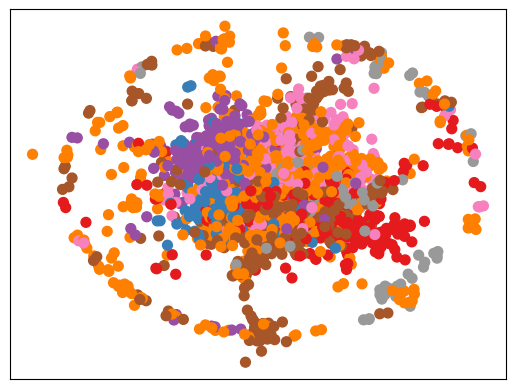

In [80]:
G = to_networkx(data, to_undirected=True)
pos = nx.spring_layout(G, seed=42)
# nx.draw(G, pos, with_labels=False, node_size=50)
labels = data.y.cpu().numpy()
nx.draw_networkx_nodes(G, pos, node_color=labels, cmap=plt.cm.Set1, node_size=50)

class_names = [
    "Case_Based",
    "Genetic_Algorithms",
    "Neural_Networks",
    "Probabilistic_Methods",
    "Reinforcement_Learning",
    "Rule_Learning",
    "Theory"
]


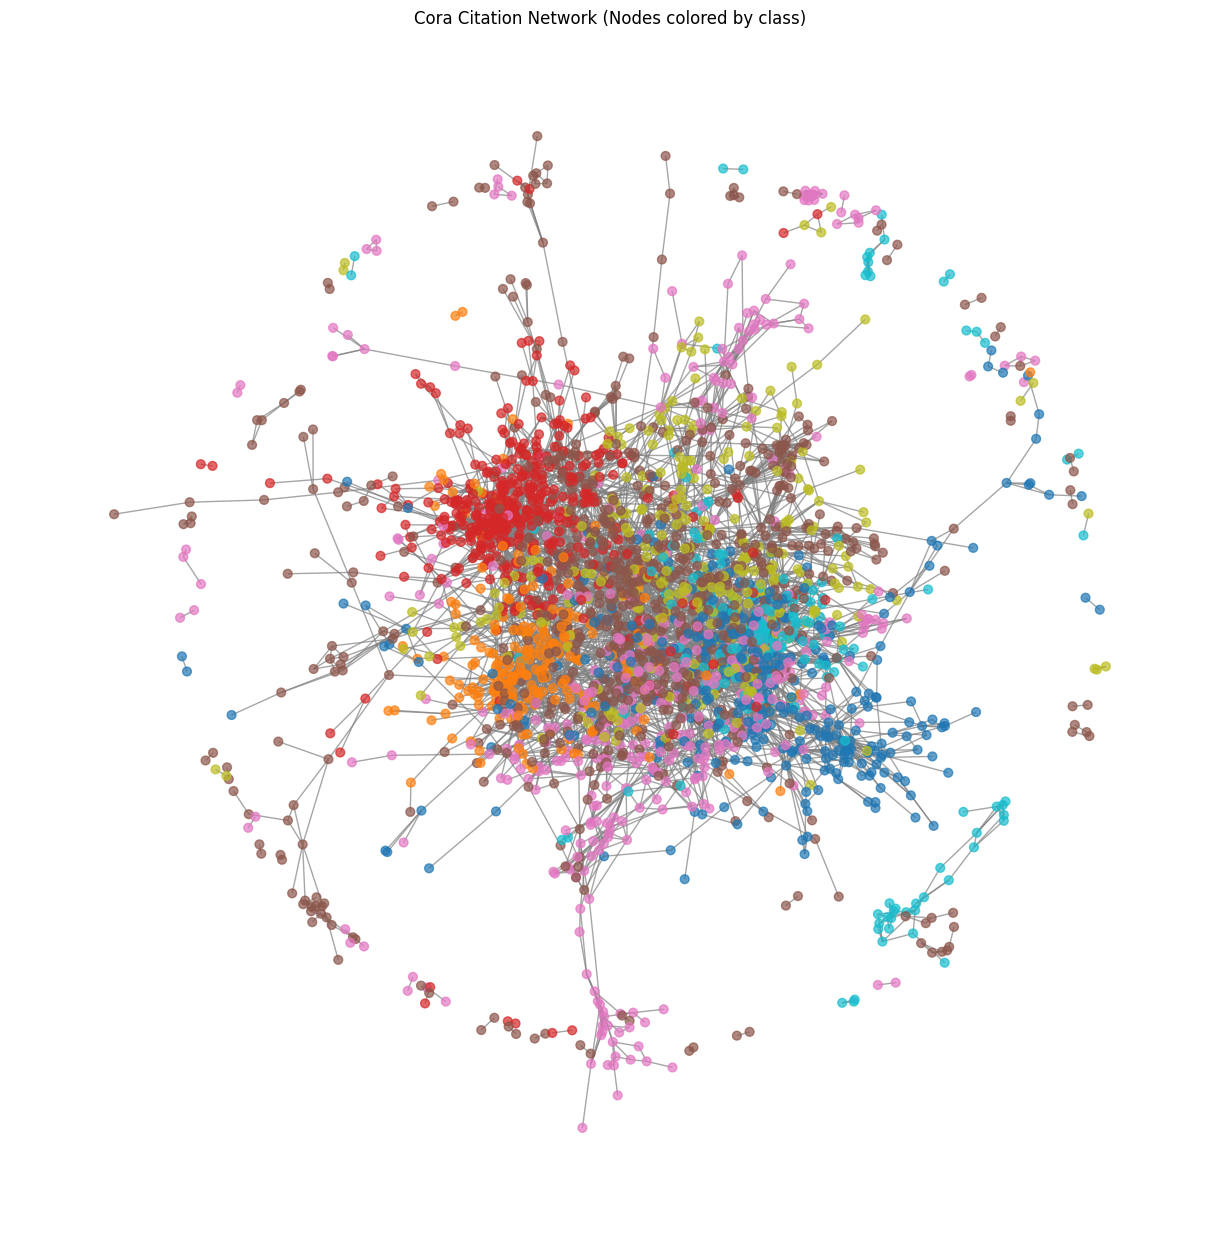

In [81]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))

nx.draw(
    G,
    pos,
    node_color=labels,
    cmap="tab10",
    node_size=40,
    edge_color="gray",
    alpha=0.7,
    with_labels=False
)

plt.title("Cora Citation Network (Nodes colored by class)")
plt.show()


In [82]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, dropout=0.5):
        super().__init__()

        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, num_classes)

        self.dropout = Dropout(p=dropout)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


In [83]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GCN(
    num_features=data.num_features,
    hidden_dim=64,
    num_classes=num_classes
).to(device)

data = data.to(device)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.01,
    weight_decay=5e-4
)

criterion = torch.nn.NLLLoss()


C:\Users\abhis\AppData\Local\Temp\ipykernel_17852\3079928063.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data.train_mask = torch.tensor(data.train_mask, dtype=torch.bool, device=device)
C:\Users\abhis\AppData\Local\Temp\ipykernel_17852\3079928063.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data.val_mask   = torch.tensor(data.val_mask,   dtype=torch.bool, device=device)
C:\Users\abhis\AppData\Local\Temp\ipykernel_17852\3079928063.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data.test_mask  = torch.tensor(data.test

Epoch 000 | Loss: 0.0075 | Val Acc: 0.7660
Epoch 010 | Loss: 0.0100 | Val Acc: 0.7800
Epoch 020 | Loss: 0.0075 | Val Acc: 0.7740
Epoch 030 | Loss: 0.0107 | Val Acc: 0.7660
Epoch 040 | Loss: 0.0069 | Val Acc: 0.7660
Epoch 050 | Loss: 0.0103 | Val Acc: 0.7660
Epoch 060 | Loss: 0.0071 | Val Acc: 0.7680
Epoch 070 | Loss: 0.0099 | Val Acc: 0.7680
Epoch 080 | Loss: 0.0084 | Val Acc: 0.7560
Epoch 090 | Loss: 0.0074 | Val Acc: 0.7600
Epoch 100 | Loss: 0.0092 | Val Acc: 0.7720
Epoch 110 | Loss: 0.0093 | Val Acc: 0.7680
Epoch 120 | Loss: 0.0088 | Val Acc: 0.7740
Epoch 130 | Loss: 0.0076 | Val Acc: 0.7740
Epoch 140 | Loss: 0.0089 | Val Acc: 0.7820
Epoch 150 | Loss: 0.0079 | Val Acc: 0.7720
Epoch 160 | Loss: 0.0077 | Val Acc: 0.7700
Epoch 170 | Loss: 0.0070 | Val Acc: 0.7660
Epoch 180 | Loss: 0.0103 | Val Acc: 0.7620
Epoch 190 | Loss: 0.0085 | Val Acc: 0.7680

Test Accuracy: 0.8010


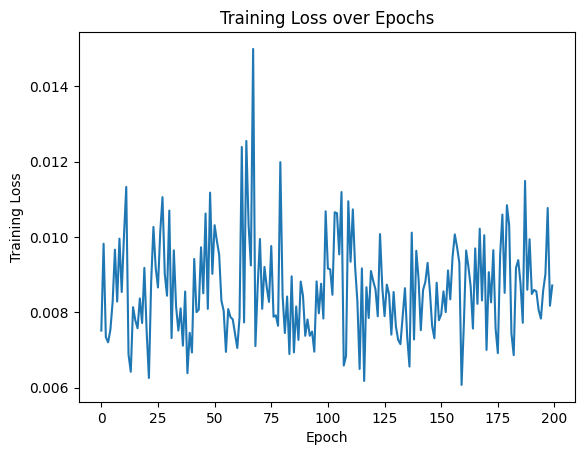

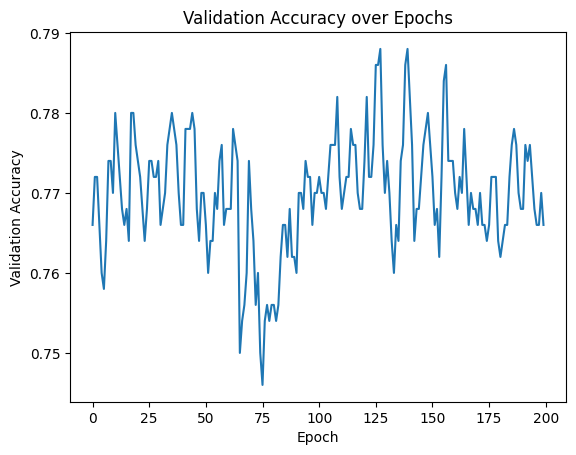

In [88]:
def train():
    model.train()
    optimizer.zero_grad()

    out = model(data.x, data.edge_index)

    loss = criterion(
        out[data.train_mask],
        data.y[data.train_mask]
    )

    loss.backward()
    optimizer.step()

    return loss.item()

def evaluate(mask):
    model.eval()

    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)

    correct = (pred[mask] == data.y[mask])
    acc = int(correct.sum()) / int(mask.sum())

    return acc

data.train_mask = torch.tensor(data.train_mask, dtype=torch.bool, device=device)
data.val_mask   = torch.tensor(data.val_mask,   dtype=torch.bool, device=device)
data.test_mask  = torch.tensor(data.test_mask,  dtype=torch.bool, device=device)


# for epoch in range(200):
#     loss = train()
#     val_acc = evaluate(data.val_mask)

#     if epoch % 10 == 0:
#         print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Val Acc: {val_acc:.4f}")

num_epochs = 200

train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # ---- Training ----
    loss = train()
    train_losses.append(loss)

    # ---- Validation ----
    val_acc = evaluate(data.val_mask)
    val_accuracies.append(val_acc)

    # ---- Logging ----
    if epoch % 10 == 0:
        print(
            f"Epoch {epoch:03d} | "
            f"Loss: {loss:.4f} | "
            f"Val Acc: {val_acc:.4f}"
        )

test_acc = evaluate(data.test_mask)
print(f"\nTest Accuracy: {test_acc:.4f}")

plt.figure()
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss over Epochs")
plt.show()

plt.figure()
plt.plot(val_accuracies)
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy over Epochs")
plt.show()

